# Yolov8 Instance Segmentation TRT tutorial

### Exporting ONNX from pytorch model and test segmentation postprocessing with ort runtime

Let's start by importing required libraries

In [52]:
from ultralytics import YOLO
import cv2
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

# import utils file fot postprocessing and visualization
import utils

Now load the desired model checkpoint and the target image

N.B. if the checkpoint is not presente in current forlder, this will automatically download it

In [53]:
model = YOLO('yolov8s-seg.pt') 
image = cv2.imread('original_bus_832x1088.jpg')

desired_image_size = (image.shape[1], image.shape[0])
desired_image_size_resize = (image.shape[0], image.shape[1])

# change input size according to the resolution of the image you want to process
# e.g. desired_image_size = (640, 640)

Now export the pytorch model to ONNX format.

Notice that you have to declare the desired input size. The resulting model will expect this specific shape at inference time, so it will not work with other image dimentions.

If your input image has different shape, you can get a sample and use it instead of <strong>original_bus_832x1088.jpg</strong>.
Otherwise, just add a resize step to the preprocessing function inside utils.py (this will change corresponsing accuracies).

In [54]:
model.export(format='onnx', imgsz=desired_image_size)

Ultralytics YOLOv8.1.17 🚀 Python-3.12.1 torch-2.2.0+cu121 CPU (11th Gen Intel Core(TM) i9-11950H 2.60GHz)
YOLOv8s-seg summary (fused): 195 layers, 11810560 parameters, 0 gradients, 42.6 GFLOPs

PyTorch: starting from 'yolov8s-seg.pt' with input shape (1, 3, 832, 1088) BCHW and output shape(s) ((1, 116, 18564), (1, 32, 208, 272)) (22.8 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 1.0s, saved as 'yolov8s-seg.onnx' (45.5 MB)

Export complete (2.9s)
Results saved to /home/matteo/Documents/my_experiments/yolov8/TensorRT-YOLOv8-Instance-Segmentation
Predict:         yolo predict task=segment model=yolov8s-seg.onnx imgsz=832,1088  
Validate:        yolo val task=segment model=yolov8s-seg.onnx imgsz=832,1088 data=coco.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[832, 1088]' will not work. Use export 'imgsz=1088' if val is required.
Visualize:       https://netron.app


'yolov8s-seg.onnx'

----------------------------------
## TEST INFERENCE WITH ONNX RUNTIME

Here we test the inference postprocessing before deploying the model with TRT.

The result of the inference with the TRT engine will have the same number of outputs and the same shapes as the one provided by ORT runtime.

In [55]:
# Load YOLOv8s-seg model saved before
model_path = 'yolov8s-seg.onnx'
ort_session = ort.InferenceSession(model_path)

### Preprocess the image

Here we preprocess the image for inference, in this example the resized image does not change the resolution of the image, but it is used for interpolation and to transpose the input tensor.

In [56]:
resized_image = cv2.resize(image, desired_image_size_resize) ## <---- if you need to resize the image
input_image = resized_image.astype(np.float32) / 255.0
input_image = np.transpose(input_image, [2, 0, 1])  # Change image layout to CHW (Channels First)
input_image = np.expand_dims(input_image, axis=0) 

### Perform inference

Now just run the inference and get outputs.

In [57]:
start_time = time.time_ns()
outputs = ort_session.run(None, {'images': input_image})
print("Inference time:", time.time_ns() - start_time, "ns")

output_0=np.squeeze(outputs[0])
prototypes=np.squeeze(outputs[1])

Inference time: 395512117 ns


In [58]:
# check the output shape
print("output_0 shape: ", output_0.shape)
print("prototypes shape: ", prototypes.shape)

output_0 shape:  (116, 18564)
prototypes shape:  (32, 208, 272)


### Visualize the resulting masks according with YOLACT postprocessing
url: https://openaccess.thecvf.com/content_ICCV_2019/papers/Bolya_YOLACT_Real-Time_Instance_Segmentation_ICCV_2019_paper.pdf

Here we show all the masks sequentially in ascending order according to confidence of bbox detections.

Number of plots: 5


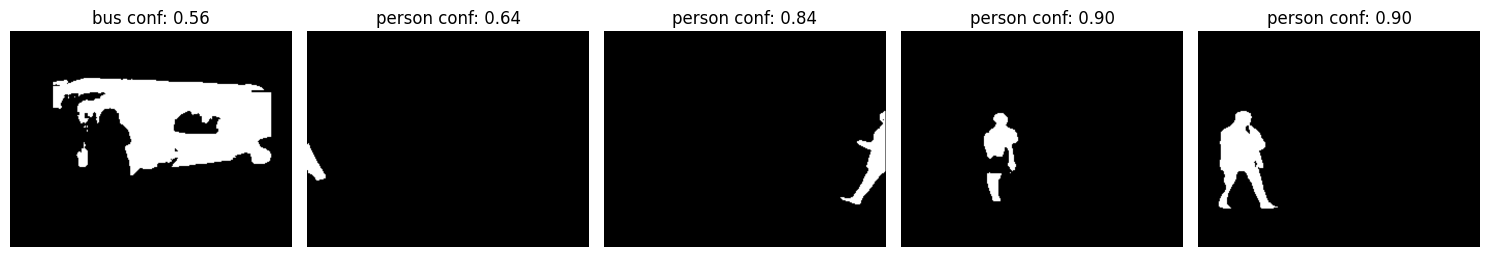

In [59]:
output_0=np.squeeze(outputs[0])
prototypes=np.squeeze(outputs[1])
l_mask,l_class,l_conf,l_boxes=utils.extract_masks(output_0,prototypes,desired_image_size)

# Determine the number of subplots needed
num_plots = len(l_mask)
print(f"Number of plots: {num_plots}")

# Calculate the number of rows and columns for the subplot grid
num_rows = 1  # Number of rows
num_cols = num_plots  # Number of columns

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Iterate over each subplot
for k, ax in enumerate(axes):
    ax.imshow(l_mask[k], cmap='gray')
    title = f"{utils.CLASSES_DICT[l_class[k]]} conf: {l_conf[k]:.2f}"
    ax.set_title(title)
    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout
plt.show()

Here we show the same result but overlapping output masks to the original image, just for showing purposes.

(-0.5, 1087.5, 831.5, -0.5)

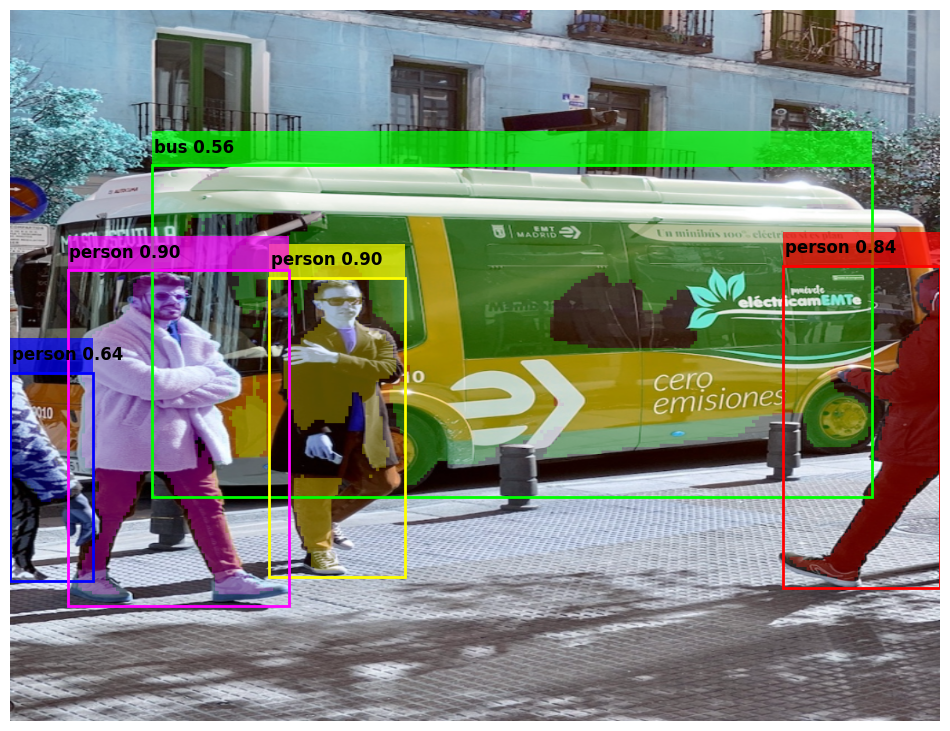

In [60]:
colors = [[0, 255, 0], [0, 0, 255], [255, 0, 0], [255, 255, 0], [255, 0, 255], 
            [0, 255, 255], [128, 0, 0], [0, 128, 0], [0, 0, 128], [128, 128, 0], 
            [128, 0, 128], [0, 128, 128], [128, 128, 128], [192, 192, 192], 
            [128, 0, 0], [128, 128, 0], [0, 128, 0], [128, 0, 128], [0, 128, 128], 
            [0, 0, 128], [255, 255, 255], [0, 0, 0]]

masked_image = np.copy(resized_image).astype(np.float32) / 255.0
opacity = 0.3

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(masked_image)

for idx, mask in enumerate(l_mask):
    color = np.array(colors[idx]) / 255.0  # Normalize color for matplotlib
    mask_rgb = np.zeros_like(resized_image, dtype=np.float32)
    mask_rgb[mask > 0] = color

    # Apply mask with opacity
    masked_image = np.where(mask_rgb > 0, mask_rgb * opacity + masked_image * (1 - opacity), masked_image)

    # Draw bounding box
    x, y, w, h = l_boxes[idx]
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    # Add label background
    label_background = patches.Rectangle((x, y - 40), w, 40, linewidth=0, edgecolor='none', facecolor=color, alpha=0.7)
    ax.add_patch(label_background)

    # Add label text
    label = f'{utils.CLASSES_DICT[l_class[idx]]} {l_conf[idx]:.2f}'
    plt.text(x + 2, y - 10, label, verticalalignment='bottom', color='black', fontsize=12, weight='bold')

# Display the image
ax.imshow(masked_image)
plt.axis('off')